# 5. Custom Neural Network for Tabular Data

### [2024.02.28] Ïù¥ÏÉÅÌòÅ

### Í∞úÏöî
- IDA 2016 ChallengeÏóêÏÑú ÏßÑÌñâÌïú APS Failure and Operational Data for Scania Trucks Îç∞Ïù¥ÌÑ∞Î•º Ïù¥Ïö©ÌïòÏó¨, Í≤∞Ï∏°ÏπòÏôÄ ÌîºÏ≥ê ÏàòÍ∞Ä ÎßéÏùÄ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú Ïù¥ÏßÑ Î∂ÑÎ•ò
- ÌïúÎ≤à Ï†ëÌï¥Î≥∏ Ï†ÅÏù¥ ÏûàÎäî Îç∞Ïù¥ÌÑ∞ÏßÄÎßå, ÏãúÍ∞ÅÌôî/Í≤∞Ï∏°Ïπò Î≥¥Í∞Ñ/ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ± Í∑∏Î¶¨Í≥† Neural NetworkÎ•º ÌôúÏö©Ìïú Î™®Îç∏ÎßÅÏùÑ ÏßÑÌñâ

### 0. GPU Configuration

üíªÎπ†Î•∏ Ïó∞ÏÇ∞ÏùÑ ÏúÑÌï¥ PyTorchÏóêÏÑú **GPU**Î•º ÏÇ¨Ïö©Ìï† Ïàò ÏûàÎèÑÎ°ù ÏÑ§Ï†ïÌï¥Ï§ÄÎã§.

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# ÏãúÎìú Í≥†Ï†ï
SEED = 228

if device == 'cuda':
    torch.cuda.manual_seed_all(SEED)
else:
    torch.manual_seed(SEED)

### 1. Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import datetime
import random
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm import tqdm

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchsummary import summary
import torchmetrics
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [5]:
sys.path.append('C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data')
os.chdir('C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data')

### 2. EDA

In [7]:
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
train = pd.read_csv('training_set.csv', encoding='utf-8-sig')
test = pd.read_csv('test_set.csv', encoding='utf-8-sig')

In [245]:
# Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Ï†ïÎ≥¥ ÌôïÏù∏
print('--------Train data Í∏∞Î≥∏ Ï†ïÎ≥¥---------')
print('{}Í∞úÏùò ÌñâÍ≥º {}Í∞úÏùò Ïó¥Ïù¥ ÏûàÏäµÎãàÎã§.'.format(train.shape[0], train.shape[1]))
print()
print('--------Train data Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ---------')
print(train.dtypes.unique())

--------Train data Í∏∞Î≥∏ Ï†ïÎ≥¥---------
55000Í∞úÏùò ÌñâÍ≥º 172Í∞úÏùò Ïó¥Ïù¥ ÏûàÏäµÎãàÎã§.

--------Train data Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ---------
[dtype('O') dtype('int64') dtype('float64')]


In [246]:
# Îç∞Ïù¥ÌÑ∞ ÌïúÎ≤à Î≥¥Í∏∞
train.head(3)

ID_code  class    X1   X2    X3     X4   X5   X6  X7a  X7b  ...    X105c  \
0  train_1      0  3490  0.0  80.0  212.0  0.0  0.0  0.0  0.0  ...  12986.0   
1  train_2      0    92  0.0  14.0   10.0  0.0  0.0  0.0  0.0  ...    512.0   
2  train_3      0    10  0.0  18.0    2.0  4.0  6.0  0.0  0.0  ...    132.0   

    X105d    X105e    X105f    X105g    X105h   X105i  X105j  X106  X107  
0  7612.0  17044.0  13682.0  19594.0  74564.0  5270.0    0.0   0.0   0.0  
1   120.0    332.0    344.0    964.0   1414.0     0.0    0.0   0.0   0.0  
2    22.0     32.0     24.0     26.0     54.0     0.0    0.0   0.0   0.0  

[3 rows x 172 columns]

In [8]:
# ID_code Ïó¥ ÏÇ≠Ï†ú
train.drop(['ID_code'], axis=1, inplace=True)
test.drop(['ID_code'], axis=1, inplace=True)

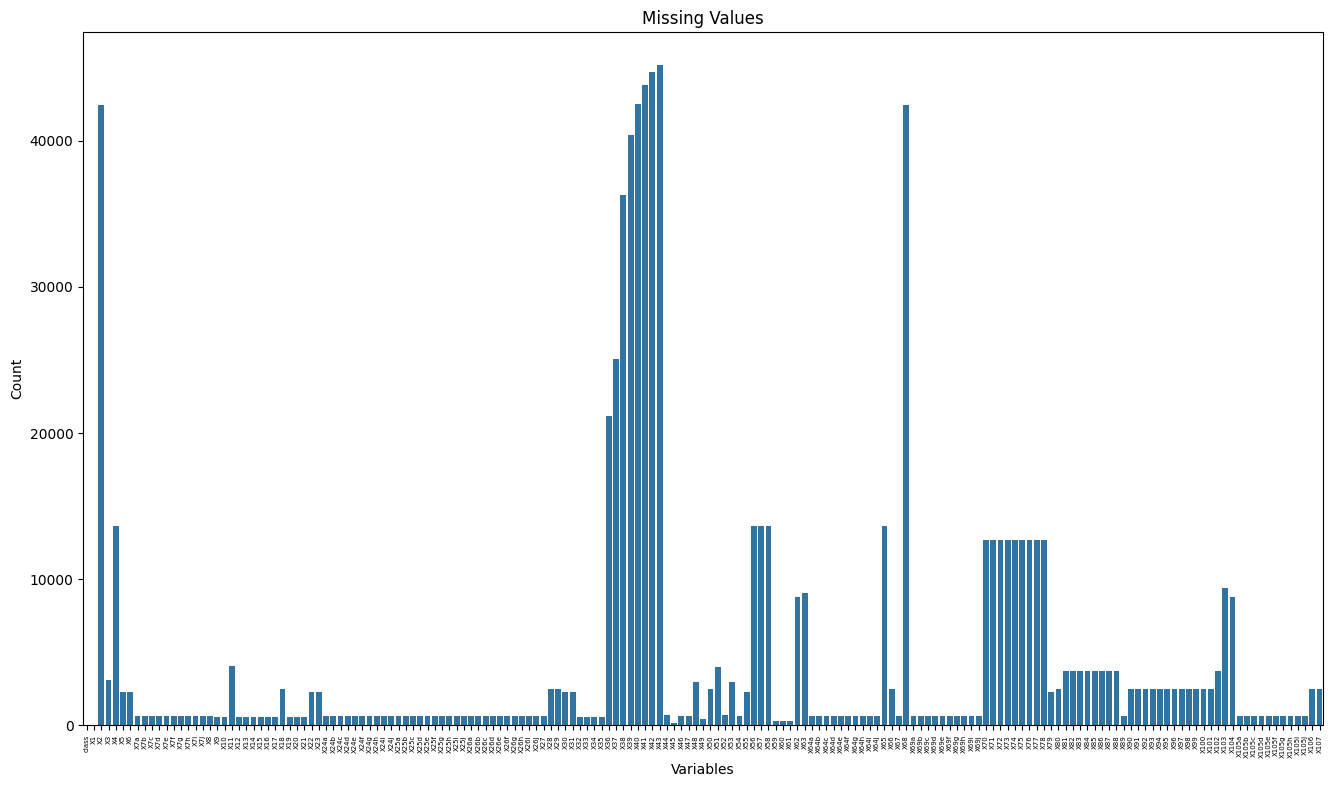

In [248]:
# Í≤∞Ï∏°Ïπò ÌôïÏù∏
train_missing = train.isna().sum()

plt.figure(figsize=(16,9))
sns.barplot(train_missing)
plt.title('Missing Values')
plt.xlabel('Variables')
plt.ylabel('Count')
plt.xticks(rotation=90, fontsize=5)
plt.show()

- Í≤∞Ï∏°ÏπòÍ∞Ä Îß§Ïö∞ ÎßéÎã§.
- Îî∞ÎùºÏÑú **Í≤∞Ï∏°ÏπòÍ∞Ä ÎåÄÎ∂ÄÎ∂ÑÏù∏ Î≥ÄÏàòÎäî ÏÇ≠Ï†ú**ÌïòÎäî Í≤ÉÏù¥ Ï¢ãÏùÑ Í≤É Í∞ôÎã§.
- **Í≤∞Ï∏°Ïπò Î≥¥Í∞Ñ** ÎòêÌïú Îß§Ïö∞ Ï§ëÏöîÌïòÎã§.

In [249]:
# Í≤∞Ï∏°Ïπò ÎπÑÏú® ÌôïÏù∏
def missing_percentage(column, threshold):
    rows_missing = column.isna().sum()
    rows = len(column)
    percentage = rows_missing/rows * 100

    if percentage >= threshold:
        print('{}Ïó¥Ïùò Í≤∞Ï∏°Ïπò Í∞úÏàòÎäî {}Í∞úÏù¥Í≥†, ÎπÑÏú®ÏùÄ {:.4f}ÏûÖÎãàÎã§.'.format(column.name, rows_missing, percentage))

    return percentage

In [250]:
# Í≤∞Ï∏°Ïπò 70% Ïù¥ÏÉÅÏù∏ Î≥ÄÏàò ÌôïÏù∏
train.apply(lambda x: missing_percentage(x, threshold=70), axis=0)

X2Ïó¥Ïùò Í≤∞Ï∏°Ïπò Í∞úÏàòÎäî 42415Í∞úÏù¥Í≥†, ÎπÑÏú®ÏùÄ 77.1182ÏûÖÎãàÎã§.
X39Ïó¥Ïùò Í≤∞Ï∏°Ïπò Í∞úÏàòÎäî 40365Í∞úÏù¥Í≥†, ÎπÑÏú®ÏùÄ 73.3909ÏûÖÎãàÎã§.
X40Ïó¥Ïùò Í≤∞Ï∏°Ïπò Í∞úÏàòÎäî 42482Í∞úÏù¥Í≥†, ÎπÑÏú®ÏùÄ 77.2400ÏûÖÎãàÎã§.
X41Ïó¥Ïùò Í≤∞Ï∏°Ïπò Í∞úÏàòÎäî 43766Í∞úÏù¥Í≥†, ÎπÑÏú®ÏùÄ 79.5745ÏûÖÎãàÎã§.
X42Ïó¥Ïùò Í≤∞Ï∏°Ïπò Í∞úÏàòÎäî 44660Í∞úÏù¥Í≥†, ÎπÑÏú®ÏùÄ 81.2000ÏûÖÎãàÎã§.
X43Ïó¥Ïùò Í≤∞Ï∏°Ïπò Í∞úÏàòÎäî 45161Í∞úÏù¥Í≥†, ÎπÑÏú®ÏùÄ 82.1109ÏûÖÎãàÎã§.
X68Ïó¥Ïùò Í≤∞Ï∏°Ïπò Í∞úÏàòÎäî 42415Í∞úÏù¥Í≥†, ÎπÑÏú®ÏùÄ 77.1182ÏûÖÎãàÎã§.


class     0.000000
X1        0.000000
X2       77.118182
X3        5.565455
X4       24.720000
           ...    
X105h     1.109091
X105i     1.109091
X105j     1.109091
X106      4.516364
X107      4.514545
Length: 171, dtype: float64

- 70% Ïù¥ÏÉÅÏù∏ Ïó¥ÏùÄ ÏßÄÏö∞ÎèÑÎ°ù Ìï¥ÏïºÍ≤†Îã§.

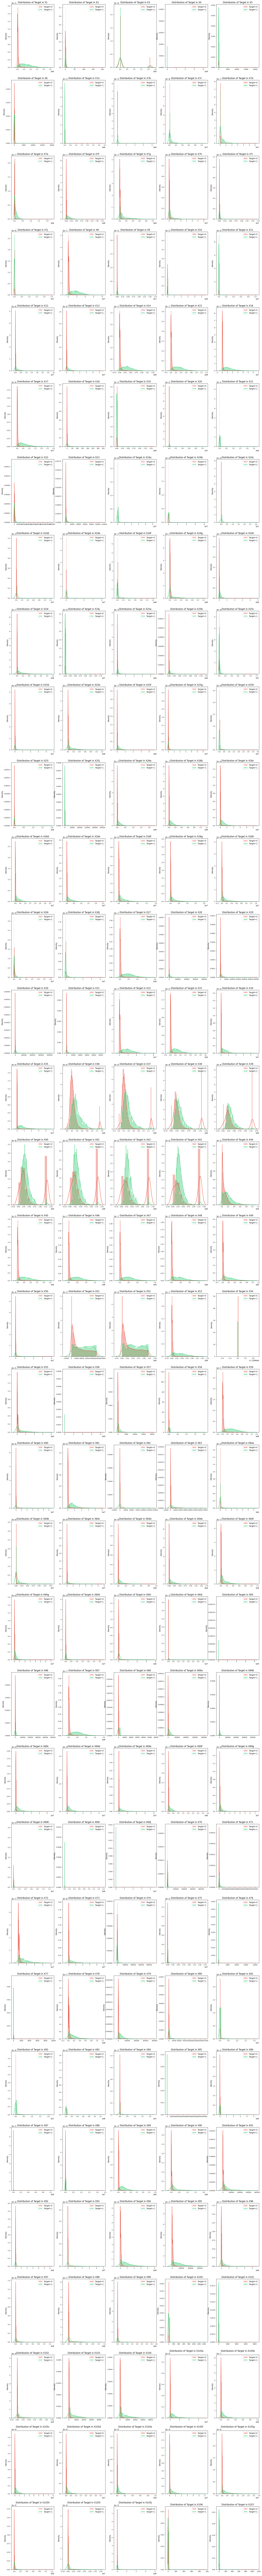

CPU times: total: 2min 29s
Wall time: 1min 23s


In [251]:
%%time

# Î≥ÄÏàòÎ≥Ñ Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
features = train.drop(['class'], axis=1).columns.tolist()

nrows = 50
fig, axs = plt.subplots(nrows=34, ncols=5, figsize=(24, nrows * 5))

for i, feature in enumerate(features, 1):
    plt.subplot(34, 5, i)

    sns.distplot((train[train['class'] == 0][feature].values), label='Target=0', hist=True, color='#e74c3c')
    sns.distplot((train[train['class'] == 1][feature].values), label='Target=1', hist=True, color='#2ecc71')

    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)

    plt.legend(loc='upper right')
    plt.xlabel('')
    plt.title('Distribution of Target in {}'.format(feature))

plt.show()

- ÎåÄÎ∂ÄÎ∂ÑÏùò Î≥ÄÏàòÏóêÏÑú Ïù¥ÏÉÅÏπòÍ∞Ä ÎÇòÌÉÄÎÇòÍ≥† ÏûàÎã§. 
- box-cox Î≥ÄÌôòÏùÑ ÏãúÎèÑÌï¥Î¥êÏïºÍ≤†Îã§.
- Ïù¥ÏÉÅÏπò Ïó¨Î∂ÄÎ•º isolation forestÎ°ú ÌåêÎã®ÌïòÍ≥† ÌååÏÉùÎ≥ÄÏàòÎ•º ÎßåÎì§ ÏàòÎèÑ ÏûàÎã§.

CPU times: total: 1min 45s
Wall time: 1min 50s


Text(0.5, 1.0, 'Correlation of Variables')

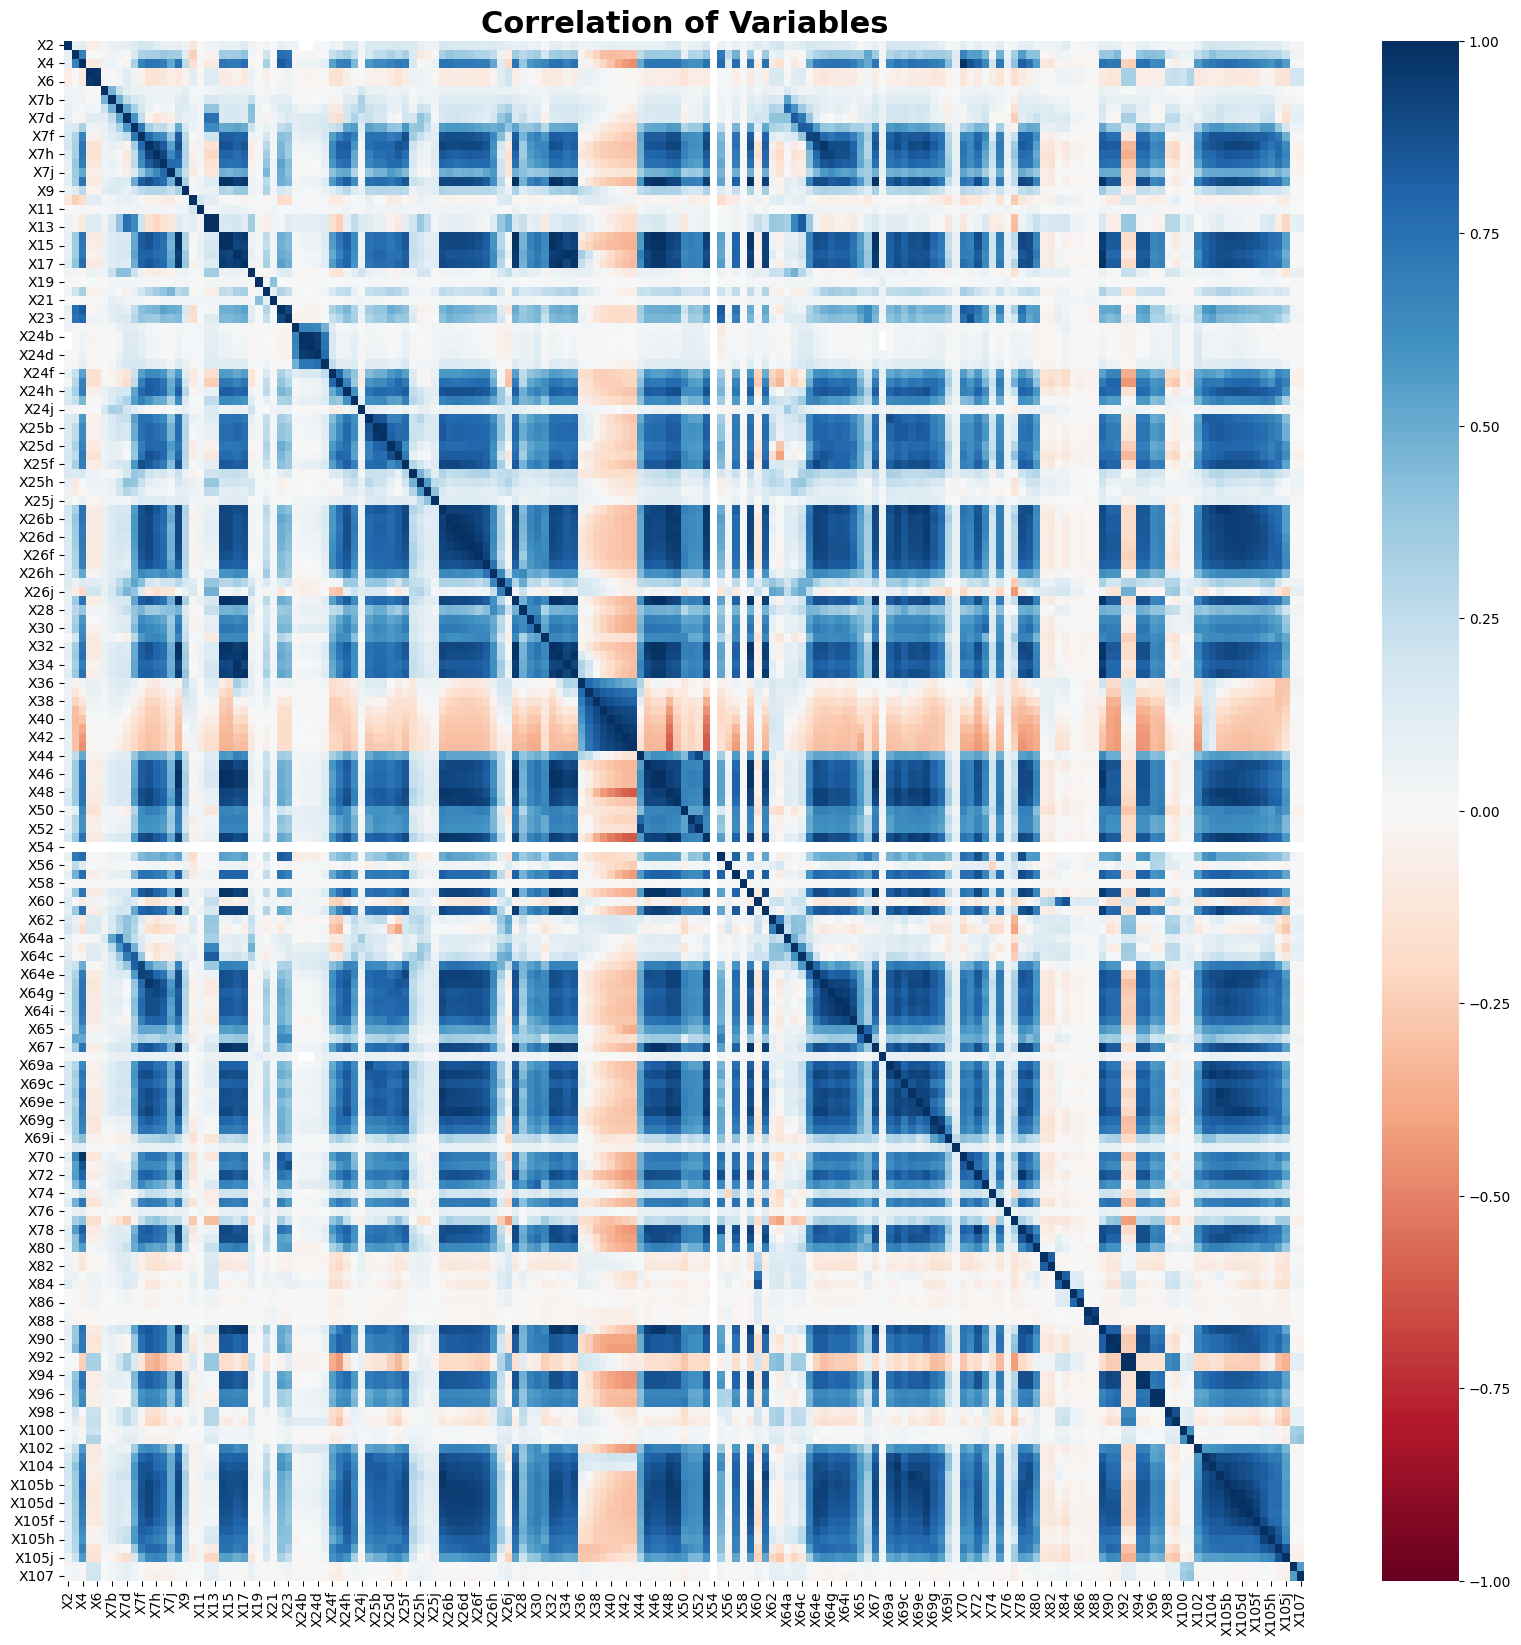

In [14]:
%%time

# Î≥ÄÏàò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏãúÍ∞ÅÌôî
num_var = train.select_dtypes(include = ['float64'])
num_corr = num_var.corr(method='spearman') # Ïù¥ÏÉÅÏπòÍ∞Ä ÎßéÍ∏∞ ÎïåÎ¨∏Ïóê Ïä§ÌîºÏñ¥Îßå ÏÉÅÍ¥ÄÍ≥ÑÏàò Í≥ÑÏÇ∞

plt.figure(figsize=(20, 20), dpi=100)
sns.heatmap(num_corr, annot=False, cmap='RdBu', vmin=-1, vmax=1, center=0)
plt.title("Correlation of Variables", fontweight="bold", fontsize = 22)

- ÎßéÏùÄ Î≥ÄÏàòÏóêÏÑú ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í∞ïÌïòÍ≤å ÎÇòÌÉÄÎÇòÍ≥† ÏûàÍ≥†, ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÇòÌÉÄÎÇòÎäî Î≥ÄÏàòÎèÑ ÏûàÎã§.

### 3. Pre-process

#### (1) Í≤∞Ï∏°Ïπò 20% Ïù¥ÏÉÅÏù∏ Ïó¥ Ï†úÍ±∞

In [9]:
# Í≤∞Ï∏°Ïπò 20% Ïù¥ÏÉÅÏù∏ Ïó¥ Ï†úÍ±∞
missing_drop_var = ['X2', 'X39', 'X40', 'X41', 'X42', 'X43', 'X68']

train.drop(columns=missing_drop_var, axis=1, inplace=True)
test.drop(columns=missing_drop_var, axis=1, inplace=True)

print(train.shape[1])

164


#### (2) Í≤∞Ï∏°Ïπò Î≥¥Í∞Ñ

- Í≤∞Ï∏°ÏπòÍ∞Ä ÎßéÏù¥ Î∞úÏÉùÌïòÎäî Î≥ÄÏàòÎäî ÏÇ≠Ï†úÌï¥Ï§¨Îã§.
- Îî∞ÎùºÏÑú KNN Îì±Ïùò Î∞©Î≤ïÏù¥ ÏïÑÎãå **Ï§ëÏïôÍ∞í**ÏúºÎ°ú Í≤∞Ï∏°ÏπòÎ•º Î≥¥Í∞ÑÌï¥Ï§ÄÎã§.

In [10]:
# train data
for var in train.columns:
    if train[var].isna().sum() != 0:
        train[var][train[var].isna()] = train[var].median()

# test data
for var in test.columns:
    if test[var].isna().sum() != 0:
        test[var][test[var].isna()] = test[var].median()

In [11]:
# Í≤∞Ï∏°Ïπò ÌôïÏù∏
train.isna().sum()

class    0
X1       0
X3       0
X4       0
X5       0
        ..
X105h    0
X105i    0
X105j    0
X106     0
X107     0
Length: 164, dtype: int64

In [12]:
train.head(3)

class    X1    X3     X4   X5   X6  X7a  X7b  X7c     X7d  ...    X105c  \
0      0  3490  80.0  212.0  0.0  0.0  0.0  0.0  0.0     0.0  ...  12986.0   
1      0    92  14.0   10.0  0.0  0.0  0.0  0.0  0.0  4528.0  ...    512.0   
2      0    10  18.0    2.0  4.0  6.0  0.0  0.0  0.0     0.0  ...    132.0   

    X105d    X105e    X105f    X105g    X105h   X105i  X105j  X106  X107  
0  7612.0  17044.0  13682.0  19594.0  74564.0  5270.0    0.0   0.0   0.0  
1   120.0    332.0    344.0    964.0   1414.0     0.0    0.0   0.0   0.0  
2    22.0     32.0     24.0     26.0     54.0     0.0    0.0   0.0   0.0  

[3 rows x 164 columns]

#### (3) Isolation Forest Ïù¥ÏÉÅÏπò ÌåêÎã®

In [13]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑ
X_train = train.drop(columns='class', axis=1)
X_test = test.copy()

In [14]:
# Isolation Forest
model = IsolationForest(max_samples=100, contamination = 0.1, random_state=SEED)

# Ïù¥ÏÉÅÏπò ÌÉêÏßÄ ÌïôÏäµ
model.fit(X_train)

# Ïù¥ÏÉÅÏπò Ïó¨Î∂Ä
anomaly = model.predict(X_train)
anomaly_score = model.decision_function(X_train)

In [15]:
# ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ±
X_train['anomaly'] = anomaly
X_train['anomaly_score'] = anomaly_score

X_train.head(3)

X1    X3     X4   X5   X6  X7a  X7b  X7c     X7d       X7e  ...    X105e  \
0  3490  80.0  212.0  0.0  0.0  0.0  0.0  0.0     0.0  179466.0  ...  17044.0   
1    92  14.0   10.0  0.0  0.0  0.0  0.0  0.0  4528.0    3486.0  ...    332.0   
2    10  18.0    2.0  4.0  6.0  0.0  0.0  0.0     0.0     224.0  ...     32.0   

     X105f    X105g    X105h   X105i  X105j  X106  X107  anomaly  \
0  13682.0  19594.0  74564.0  5270.0    0.0   0.0   0.0        1   
1    344.0    964.0   1414.0     0.0    0.0   0.0   0.0        1   
2     24.0     26.0     54.0     0.0    0.0   0.0   0.0        1   

   anomaly_score  
0       0.115560  
1       0.125131  
2       0.129808  

[3 rows x 165 columns]

In [16]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÎèÑ Ï†ÅÏö©
test_anomaly = model.predict(X_test)
test_anomaly_score = model.decision_function(X_test)

In [17]:
# ÌååÏÉùÎ≥ÄÏàò ÏÉùÏÑ±
X_test['anomaly'] = test_anomaly
X_test['anomaly_score'] = test_anomaly_score

X_test.head(3)

X1      X3      X4   X5   X6  X7a  X7b  X7c  X7d       X7e  ...  \
0  40766  3772.0  3428.0  0.0  0.0  0.0  0.0  0.0  0.0  158424.0  ...   
1   9030   174.0   134.0  0.0  0.0  0.0  0.0  0.0  0.0     600.0  ...   
2  93156     0.0   134.0  0.0  0.0  0.0  0.0  0.0  0.0  137692.0  ...   

      X105e     X105f     X105g     X105h     X105i    X105j  X106  X107  \
0  229834.0  187858.0  152914.0  128300.0  444178.0  96764.0   0.0   0.0   
1  151522.0   91412.0    1092.0      76.0       2.0      0.0   0.0   0.0   
2  754554.0  603766.0  495852.0  351452.0  427714.0   3004.0   0.0   0.0   

   anomaly  anomaly_score  
0        1       0.075818  
1        1       0.087338  
2       -1      -0.022854  

[3 rows x 165 columns]

In [18]:
new_train = X_train.copy()
new_test = X_test.copy()

In [19]:
# train Îç∞Ïù¥ÌÑ∞Ïóê class Ïó¥ Î∂ôÏù¥Í∏∞
new_train['class'] = train['class']

new_train.head(3)

X1    X3     X4   X5   X6  X7a  X7b  X7c     X7d       X7e  ...    X105f  \
0  3490  80.0  212.0  0.0  0.0  0.0  0.0  0.0     0.0  179466.0  ...  13682.0   
1    92  14.0   10.0  0.0  0.0  0.0  0.0  0.0  4528.0    3486.0  ...    344.0   
2    10  18.0    2.0  4.0  6.0  0.0  0.0  0.0     0.0     224.0  ...     24.0   

     X105g    X105h   X105i  X105j  X106  X107  anomaly  anomaly_score  class  
0  19594.0  74564.0  5270.0    0.0   0.0   0.0        1       0.115560      0  
1    964.0   1414.0     0.0    0.0   0.0   0.0        1       0.125131      0  
2     26.0     54.0     0.0    0.0   0.0   0.0        1       0.129808      0  

[3 rows x 166 columns]

In [20]:
new_test.head(3)

X1      X3      X4   X5   X6  X7a  X7b  X7c  X7d       X7e  ...  \
0  40766  3772.0  3428.0  0.0  0.0  0.0  0.0  0.0  0.0  158424.0  ...   
1   9030   174.0   134.0  0.0  0.0  0.0  0.0  0.0  0.0     600.0  ...   
2  93156     0.0   134.0  0.0  0.0  0.0  0.0  0.0  0.0  137692.0  ...   

      X105e     X105f     X105g     X105h     X105i    X105j  X106  X107  \
0  229834.0  187858.0  152914.0  128300.0  444178.0  96764.0   0.0   0.0   
1  151522.0   91412.0    1092.0      76.0       2.0      0.0   0.0   0.0   
2  754554.0  603766.0  495852.0  351452.0  427714.0   3004.0   0.0   0.0   

   anomaly  anomaly_score  
0        1       0.075818  
1        1       0.087338  
2       -1      -0.022854  

[3 rows x 165 columns]

- 3Í∞ÄÏßÄ Ï†ÑÏ≤òÎ¶¨Î•º ÏôÑÎ£åÌñàÎã§.

### 4. Data Loader

- Ïù¥Ï†ú ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Îäî Î™®Îëê ÏôÑÎ£åÎêòÏóàÎã§.
- ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞Î•º ÏôÑÏÑ±ÌïòÍ≥† Ïù¥Î•º Ïã†Í≤ΩÎßùÏóê ÏûÖÎ†•ÌïòÍ∏∞ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞Î°úÎçîÎ°ú Ï†ïÏùòÌïòÏûê.

In [380]:
# target, label Î∂ÑÎ¶¨
X = new_train.drop(columns='class', axis=1)
y = new_train['class']

In [381]:
# Train Îç∞Ïù¥ÌÑ∞, Test Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y) # ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Îç∞Ïù¥ÌÑ∞Ïù¥Í∏∞ ÎïåÎ¨∏Ïóê stratify Ï†ÅÏö©

In [382]:
# Îç∞Ïù¥ÌÑ∞Î•º ÌÖêÏÑúÎ°ú ÎßåÎì§Í∏∞ ÏúÑÌïú ÌÅ¥ÎûòÏä§
class CustomDatataset(Dataset):
    def __init__(self, X_data, y_data, phase='train'):
        self.X_data = torch.tensor(X_data.values, dtype=torch.float32)
        self.y_data = torch.tensor(y_data.values.flatten(), dtype=torch.float32)
        self.phase = phase

    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [383]:
# Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
train_datasets = CustomDatataset(X_train, y_train)
valid_datasets = CustomDatataset(X_val, y_val)

**Ï∞∏Í≥†**
- csv ÌòïÏãùÏùò Îç∞Ïù¥ÌÑ∞Î•º tensorÎ°ú ÎßåÎì§Ïñ¥Ï£ºÍ∏∞ ÏúÑÌï¥ÏÑúÎäî .valuesÎ•º ÏÇ¨Ïö©Ìï¥Ïïº ÌïúÎã§.
- [Stackoverflow](https://stackoverflow.com/questions/51858067/parsing-csv-into-pytorch-tensors)Î•º Ï∞∏Í≥†Ìï®

In [384]:
# Ï≤´Î≤àÎïå Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞
print(train_datasets.__getitem__(0)[0].size())

# Ï≤´Î≤àÎïå Îç∞Ïù¥ÌÑ∞
print(train_datasets.__getitem__(0)[0])

# Ï≤´Î≤àÏß∏ Îç∞Ïù¥ÌÑ∞Ïùò label
print(train_datasets.__getitem__(0)[1])

torch.Size([165])
tensor([1.0000e+01, 1.0000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8000e+01, 4.5960e+03, 5.6420e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9620e+03, 0.0000e+00, 1.6400e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3818e+04, 1.0884e+04, 5.5960e+03,
        6.1000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2000e+01,
        4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0260e+03, 9.2400e+03, 0.0000e+00, 1.1120e+03,
        1.2000e+01, 1.0000e+01, 1.6000e+01, 2.0000e+01, 2.2180e+03, 6.8780e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.9860e+03, 3.4400e+02, 9.0000e+01,
        5.6000e+01, 2.0200e+02, 6.0000e+01, 3.9600e+02, 5.6000e+01, 1.2000e+01,
        6.4000e+01, 1.9438e+04, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        3.9620e+03, 2.0800e+02, 2.3180e+03, 3.1920e+03, 2.1100e+05, 2.2278e+05,
        2.3906e+05, 5.

In [385]:
# Îç∞Ïù¥ÌÑ∞Î°úÎçî Ï†ïÏùò
train_dataloader = DataLoader(train_datasets, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid_datasets, batch_size=128, shuffle=True)

### 5. Model Training

In [52]:
# Cost Ìï®Ïàò Ï†ïÏùò
def custom_cost_function(prediction, actual):
 
    FN = ((prediction == 0) & (actual == 1)).sum()
    FP = ((prediction == 1) & (actual == 0)).sum()

    cost = 250 * FN + 5 * FP
    
    return cost

In [387]:
# Acc, f1, Cost Ï†êÏàò Î∞òÌôò Ìï®Ïàò
def get_score(prediction, actual):
    # Acc
    acc_metric = BinaryAccuracy().to(device)
    acc_score = acc_metric(prediction, actual)

    # f1
    f1_metric = BinaryF1Score().to(device)
    f1score = f1_metric(prediction, actual)

    cost_score = custom_cost_function(prediction, actual)

    return acc_score.item(), f1score.item(), cost_score.item()

In [388]:
def train_model(model, train_dataloader, criterion, optimizer, device):
    model.train() # Î™®Îç∏ÏùÑ ÌïôÏäµ Î™®ÎìúÎ°ú Ï†ÑÌôò

    train_loss = 0
    train_acc = 0
    train_f1 = 0
    train_cost = 0

    for x, y in tqdm(train_dataloader, desc = 'Training'):
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        loss = criterion(outputs, y)

        # ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî
        optimizer.zero_grad()

        # Ïó≠Ï†ÑÌåå
        loss.backward()
        optimizer.step()

        train_loss = train_loss + loss.item()
        
        # metric Í≥ÑÏÇ∞
        prediction = (outputs >= 0.5).int()
        train_acc, train_f1, train_cost = get_score(prediction, y)

    return train_loss / len(train_dataloader), train_acc, train_f1, train_cost

In [389]:
def valid_model(model, valid_dataloader, criterion, device): # Ïó≠Ï†ÑÌååÎ•º ÏßÑÌñâÌïòÏßÄ ÏïäÍ∏∞ ÎñÑÎ¨∏Ïóê ÏòµÌã∞ÎßàÏù¥Ï†Ä ÌïÑÏöî ÏóÜÏùå
    model.eval() # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú Ï†ÑÌôò

    valid_loss = 0
    valid_acc = 0
    valid_f1 = 0
    valid_cost = 0

    for x, y in tqdm(valid_dataloader, desc='Validation'):
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad(): # Gradient Í≥ÑÏÇ∞ÏùÑ ÎπÑÌôúÏÑ±Ìôî
            outputs = model(x)
            loss = criterion(outputs, y)
        
        valid_loss += loss.item()
        
        # metric Í≥ÑÏÇ∞
        prediction = (outputs >= 0.5).int()
        valid_acc, valid_f1, valid_cost = get_score(prediction, y)

    return valid_loss / len(valid_dataloader), valid_acc, valid_f1, valid_cost

In [390]:
def model_training(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, wait_for_es):
    train_loss_history, train_acc_history, train_f1_history, train_cost_history = [], [], [], [] # ÌõàÎ†® Í≥ºÏ†ï Í∏∞Î°ù
    valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history = [], [], [], [] # ÌèâÍ∞Ä Í≥ºÏ†ï Í∏∞Î°ù

    # Ï°∞Í∏∞ Ï¢ÖÎ£åÎ•º ÏúÑÌïú Ï°∞Í±¥ ÏÑ§Ï†ï
    best_loss = 10 ** 5
    count = 0

    # Í∞ÄÏû• ÏÑ±Îä•Ïù¥ Ï¢ãÏùÄ Î™®Îç∏ÏùÑ Ï†ÄÏû•ÌïòÍ∏∞ ÏúÑÌïú Ï°∞Í±¥
    best_acc = 0

    # Í≤ΩÍ≥º ÏãúÍ∞Ñ Í∏∞Î°ù ÏãúÏûë
    start_time = time.time() 

    for epoch in range(num_epochs):
        print('-'*80)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-'*80)

        train_loss, train_acc, train_f1, train_cost = train_model(model, train_dataloader, criterion, optimizer, device) # ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞Î°úÎçîÎ°úÎ∂ÄÌÑ∞ ÌïôÏäµ
        valid_loss, valid_acc, valid_f1, valid_cost = valid_model(model, valid_dataloader, criterion, device) # ÌèâÍ∞ÄÏö© Îç∞Ïù¥ÌÑ∞Î°úÎçîÎ°úÎ∂ÄÌÑ∞ ÌèâÍ∞Ä


        # Îß§ epochÎßàÎã§ ÌïôÏäµ Í∏∞Î°ù Ï†ÄÏû•
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        train_f1_history.append(train_f1)
        train_cost_history.append(train_cost)

        # Îß§ epochÎßàÎã§ ÌèâÍ∞Ä Í∏∞Î°ù Ï†ÄÏû•
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)
        valid_f1_history.append(valid_f1)
        valid_cost_history.append(valid_cost)

        # Í≤ΩÍ≥º Ï¢ÖÎ£å ÏãúÍ∞Ñ Í∏∞Î°ù
        end_time = time.time()

        # Ï¥ù Í±∏Î¶∞ ÏãúÍ∞Ñ
        elapsed_time = end_time - start_time
        
        print('[Train] \t Loss: {:.4f} \t Acc: {:.4f} \t F1: {:.4f} \t Cost: {:.4f}'.format(train_loss, train_acc, train_f1, train_cost))
        print('[Valid] \t Loss: {:.4f} \t Acc: {:.4f} \t F1: {:.4f} \t Cost: {:.4f}'.format(valid_loss, valid_acc, valid_f1, valid_cost))
        print('(Epoch {} complete in {:.0f}m {:.0f}s)'.format(epoch+1, elapsed_time // 60, elapsed_time % 60))

        # ÏÑ±Îä•Ïù¥ Ï¢ãÏùÄ Î™®Îç∏ Ï†ÄÏû•
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), './model/CustomDNN' + str(epoch+1) + '.pth')

        # Ï°∞Í∏∞Ï¢ÖÎ£å Ï°∞Í±¥ ÌôïÏù∏
        if valid_loss < best_loss:
            best_loss = valid_loss
        else:
            count += 1

            if count >= wait_for_es:
                print('-----<Early Stopping at Epoch {}>-----'.format(str(epoch + 1)))
                break

    return train_loss_history, train_acc_history, train_f1_history, train_cost_history, valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history

Î™®Îç∏ ÌïôÏäµÍ≥º ÌèâÍ∞ÄÎ•º ÏúÑÌïú Ìï®ÏàòÎ•º Î™®Îëê ÏûëÏÑ±ÌñàÎã§. Ïù¥Ï†ú Î™®Îç∏ÏùÑ Ï†ïÏùòÌïòÍ≥† ÌïôÏäµÏãúÏºúÎ≥¥Ïûê.

In [21]:
# Î™®Îç∏
class CustomDNN(nn.Module):
    def __init__(self):
        super(CustomDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=165, out_features=83)
        self.relu1 = nn.ReLU() 
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=83, out_features=40)
        self.relu2 = nn.ReLU() 
        self.fc3 = nn.Linear(in_features=40, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out.squeeze()  # Ï∂úÎ†• ÌÅ¨Í∏∞Î•º [batch_size]Î°ú Ï°∞Ï†ï

In [22]:
# Î™®Îç∏ Ï†ïÏùò
model = CustomDNN()
model.to(device)

CustomDNN(
  (fc1): Linear(in_features=165, out_features=83, bias=True)
  (relu1): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=83, out_features=40, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=40, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [393]:
# Î™®Îç∏ ÌååÎùºÎØ∏ÌÑ∞ Í∞úÏàò ÌôïÏù∏
summary(model, input_size=(165, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 83]          13,778
              ReLU-2                   [-1, 83]               0
           Dropout-3                   [-1, 83]               0
            Linear-4                   [-1, 40]           3,360
              ReLU-5                   [-1, 40]               0
            Linear-6                    [-1, 1]              41
           Sigmoid-7                    [-1, 1]               0
Total params: 17,179
Trainable params: 17,179
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [394]:
# trainable parameter ÌôïÏù∏ Î∞©Î≤ï
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameter(model):,} trainable parameters')

The model has 17,179 trainable parameters


In [395]:
# ÏòµÌã∞ÎßàÏù¥Ï†Ä, ÏÜêÏã§Ìï®Ïàò Ï†ïÏùò
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.BCEWithLogitsLoss().to(device)

In [396]:
# ÌååÎùºÎØ∏ÌÑ∞ Ï†ïÏùò
num_epochs = 100
wait_for_es = 10

In [397]:
# Î™®Îç∏ ÌïôÏäµ
train_loss_history, train_acc_history, train_f1_history, train_cost_history, valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history = model_training(model, 
                                                                                                                                                                          train_dataloader, 
                                                                                                                                                                          val_dataloader, 
                                                                                                                                                                          criterion, 
                                                                                                                                                                          optimizer, 
                                                                                                                                                                          device, 
                                                                                                                                                                          num_epochs,
                                                                                                                                                                          wait_for_es)

--------------------------------------------------------------------------------
Epoch 1/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 47.72it/s]


[Train] 	 Loss: 1.1941 	 Acc: 0.4100 	 F1: 0.0328 	 Cost: 295.0000
[Valid] 	 Loss: 0.9052 	 Acc: 0.5259 	 F1: 0.0000 	 Cost: 520.0000
(Epoch 1 complete in 0m 11s)
--------------------------------------------------------------------------------
Epoch 2/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 53.39it/s]


[Train] 	 Loss: 0.8996 	 Acc: 0.7700 	 F1: 0.0000 	 Cost: 605.0000
[Valid] 	 Loss: 0.6952 	 Acc: 0.9483 	 F1: 0.0000 	 Cost: 1010.0000
(Epoch 2 complete in 0m 21s)
--------------------------------------------------------------------------------
Epoch 3/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 54.16it/s]


[Train] 	 Loss: 0.8081 	 Acc: 0.8500 	 F1: 0.0000 	 Cost: 320.0000
[Valid] 	 Loss: 0.6937 	 Acc: 0.9914 	 F1: 0.0000 	 Cost: 250.0000
(Epoch 3 complete in 0m 30s)
--------------------------------------------------------------------------------
Epoch 4/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 52.12it/s]


[Train] 	 Loss: 0.7825 	 Acc: 0.8400 	 F1: 0.1111 	 Cost: 325.0000
[Valid] 	 Loss: 0.6936 	 Acc: 0.9569 	 F1: 0.0000 	 Cost: 1250.0000
(Epoch 4 complete in 0m 40s)
--------------------------------------------------------------------------------
Epoch 5/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 48.46it/s]


[Train] 	 Loss: 0.7651 	 Acc: 0.8800 	 F1: 0.0000 	 Cost: 60.0000
[Valid] 	 Loss: 0.6933 	 Acc: 0.9914 	 F1: 0.0000 	 Cost: 250.0000
(Epoch 5 complete in 0m 50s)
--------------------------------------------------------------------------------
Epoch 6/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:03<00:00, 42.89it/s]


[Train] 	 Loss: 0.7632 	 Acc: 0.8700 	 F1: 0.0000 	 Cost: 65.0000
[Valid] 	 Loss: 0.6933 	 Acc: 0.9914 	 F1: 0.0000 	 Cost: 250.0000
(Epoch 6 complete in 1m 1s)
--------------------------------------------------------------------------------
Epoch 7/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 54.29it/s]


[Train] 	 Loss: 0.7504 	 Acc: 0.9300 	 F1: 0.0000 	 Cost: 280.0000
[Valid] 	 Loss: 0.6933 	 Acc: 0.9741 	 F1: 0.0000 	 Cost: 505.0000
(Epoch 7 complete in 1m 10s)
--------------------------------------------------------------------------------
Epoch 8/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 56.73it/s]


[Train] 	 Loss: 0.7479 	 Acc: 0.9200 	 F1: 0.0000 	 Cost: 530.0000
[Valid] 	 Loss: 0.6932 	 Acc: 0.9828 	 F1: 0.0000 	 Cost: 500.0000
(Epoch 8 complete in 1m 19s)
--------------------------------------------------------------------------------
Epoch 9/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 51.60it/s]


[Train] 	 Loss: 0.7298 	 Acc: 0.9500 	 F1: 0.0000 	 Cost: 515.0000
[Valid] 	 Loss: 0.6931 	 Acc: 0.9741 	 F1: 0.0000 	 Cost: 750.0000
(Epoch 9 complete in 1m 29s)
--------------------------------------------------------------------------------
Epoch 10/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 59.92it/s]


[Train] 	 Loss: 0.7235 	 Acc: 0.9100 	 F1: 0.0000 	 Cost: 535.0000
[Valid] 	 Loss: 0.6931 	 Acc: 0.9741 	 F1: 0.0000 	 Cost: 750.0000
(Epoch 10 complete in 1m 37s)
--------------------------------------------------------------------------------
Epoch 11/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 59.23it/s]


[Train] 	 Loss: 0.7236 	 Acc: 0.9300 	 F1: 0.0000 	 Cost: 525.0000
[Valid] 	 Loss: 0.6931 	 Acc: 0.9914 	 F1: 0.0000 	 Cost: 250.0000
(Epoch 11 complete in 1m 46s)
--------------------------------------------------------------------------------
Epoch 12/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 51.85it/s]


[Train] 	 Loss: 0.7214 	 Acc: 0.9400 	 F1: 0.0000 	 Cost: 765.0000
[Valid] 	 Loss: 0.6931 	 Acc: 1.0000 	 F1: 0.0000 	 Cost: 0.0000
(Epoch 12 complete in 1m 56s)
--------------------------------------------------------------------------------
Epoch 13/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:03<00:00, 37.15it/s]


[Train] 	 Loss: 0.7185 	 Acc: 0.9500 	 F1: 0.0000 	 Cost: 760.0000
[Valid] 	 Loss: 0.6931 	 Acc: 0.9569 	 F1: 0.0000 	 Cost: 1250.0000
(Epoch 13 complete in 2m 7s)
--------------------------------------------------------------------------------
Epoch 14/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 50.23it/s]


[Train] 	 Loss: 0.7194 	 Acc: 0.9600 	 F1: 0.0000 	 Cost: 265.0000
[Valid] 	 Loss: 0.6931 	 Acc: 0.9914 	 F1: 0.0000 	 Cost: 250.0000
(Epoch 14 complete in 2m 17s)
--------------------------------------------------------------------------------
Epoch 15/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 53.71it/s]


[Train] 	 Loss: 0.7191 	 Acc: 0.9600 	 F1: 0.0000 	 Cost: 20.0000
[Valid] 	 Loss: 0.6931 	 Acc: 1.0000 	 F1: 0.0000 	 Cost: 0.0000
(Epoch 15 complete in 2m 28s)
--------------------------------------------------------------------------------
Epoch 16/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 56.04it/s]


[Train] 	 Loss: 0.7189 	 Acc: 0.9800 	 F1: 0.0000 	 Cost: 10.0000
[Valid] 	 Loss: 0.6931 	 Acc: 0.9655 	 F1: 0.0000 	 Cost: 1000.0000
(Epoch 16 complete in 2m 37s)
--------------------------------------------------------------------------------
Epoch 17/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 52.67it/s]


[Train] 	 Loss: 0.7176 	 Acc: 0.9200 	 F1: 0.0000 	 Cost: 775.0000
[Valid] 	 Loss: 0.6931 	 Acc: 0.9828 	 F1: 0.0000 	 Cost: 500.0000
(Epoch 17 complete in 2m 46s)
--------------------------------------------------------------------------------
Epoch 18/100
--------------------------------------------------------------------------------


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 129/129 [00:02<00:00, 46.15it/s]

[Train] 	 Loss: 0.7064 	 Acc: 0.9500 	 F1: 0.0000 	 Cost: 1005.0000
[Valid] 	 Loss: 0.6931 	 Acc: 0.9828 	 F1: 0.0000 	 Cost: 500.0000
(Epoch 18 complete in 2m 57s)
-----<Early Stopping at Epoch 18>-----


In [400]:
# ÌïôÏäµ Í≥ºÏ†ï ÏãúÍ∞ÅÌôî Ìï®Ïàò
def plot_training_history(train_loss_history, train_acc_history, train_f1_history, train_cost_history, 
                          valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    plt.subplot(2, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(2, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Score Plot
    plt.subplot(2, 2, 3)
    plt.plot(train_f1_history, label='Train F1 Score')
    plt.plot(valid_f1_history, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Cost Plot
    plt.subplot(2, 2, 4)
    plt.plot(train_cost_history, label='Train Cost')
    plt.plot(valid_cost_history, label='Validation Cost')
    plt.title('Training and Validation Cost')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.legend()

    plt.tight_layout()
    plt.show()

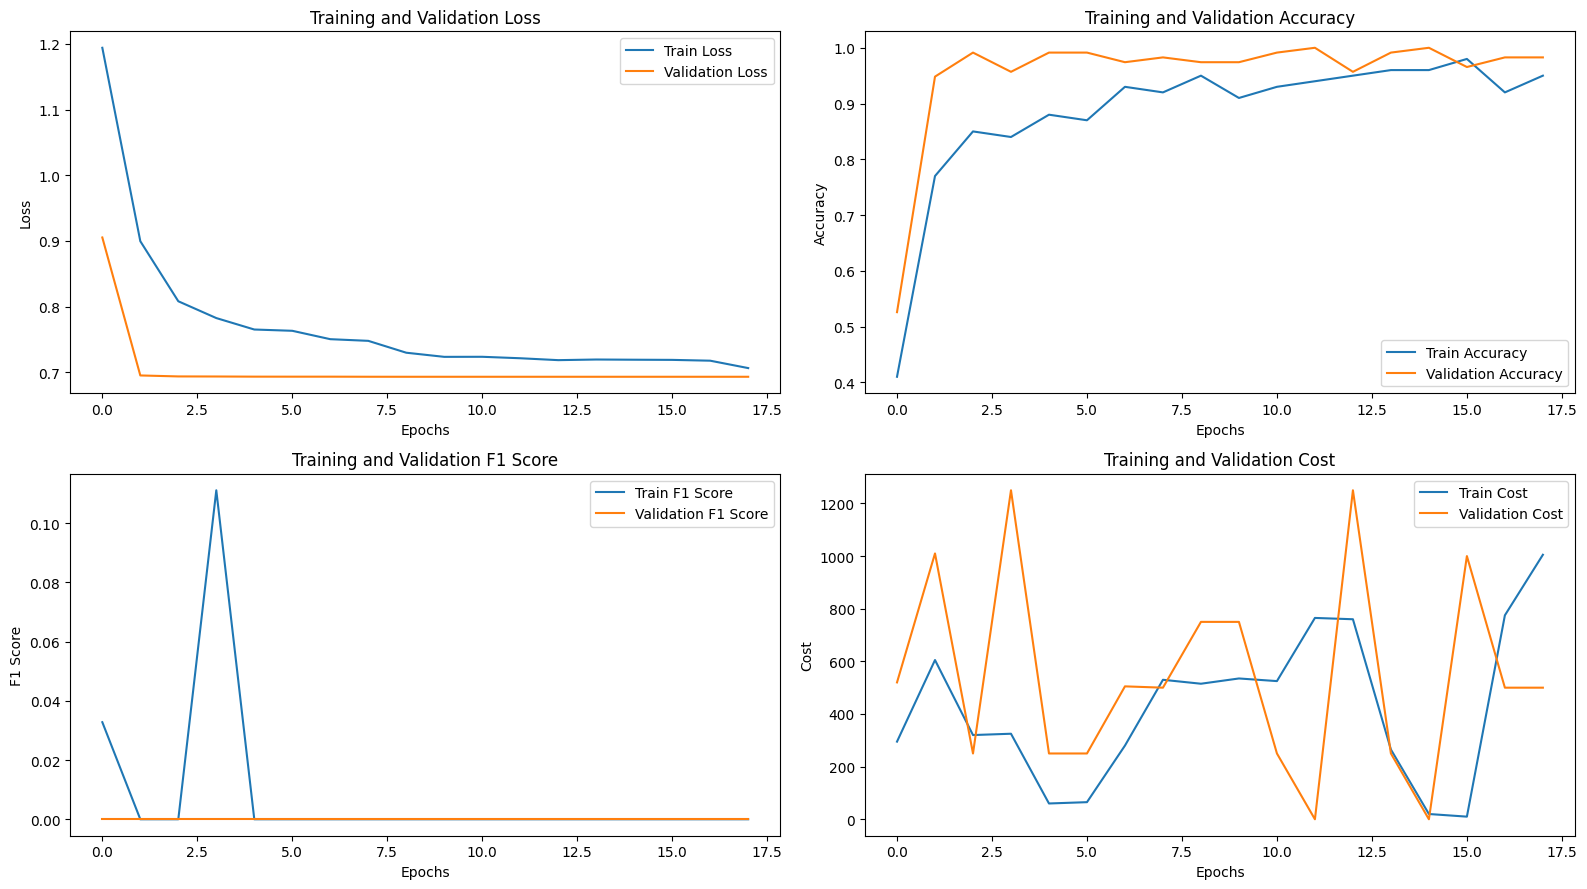

In [401]:
plot_training_history(train_loss_history, train_acc_history, train_f1_history, train_cost_history, 
                      valid_loss_history, valid_acc_history, valid_f1_history, valid_cost_history)

### 6. Model Inference

In [23]:
from torch.utils.data import TensorDataset, DataLoader
new_test_tensor = torch.tensor(new_test.values, dtype=torch.float32)
test_dataset = TensorDataset(new_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [26]:
saved_model = glob.glob('C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model/' + '*.pth') # pth ÌôïÏû•Ïûê ÌååÏùºÏùÑ Í∞ÄÏ†∏Ïò§Í∏∞
saved_model.sort()
print('Saved Model :', saved_model)

# Í∞Å Î™®Îç∏Î≥Ñ ÏòàÏ∏° Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
model_predictions = {}

for model_path in saved_model:
    print('Load Model:', model_path)
    
    # Î™®Îç∏ ÏÉÅÌÉú Î∂àÎü¨Ïò§Í∏∞
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    
    # ÌòÑÏû¨ Î™®Îç∏Ïùò ÏòàÏ∏°Í∞íÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
    predictions = []

    for inputs in tqdm(test_dataloader, desc='Testing'):
        inputs = inputs[0].to(device)  # ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞

        with torch.no_grad():
            outputs = model(inputs)
        
        # Ï∂úÎ†•ÏùÑ Ïù¥ÏßÑ Î†àÏù¥Î∏îÎ°ú Î≥ÄÌôò
        pred = (outputs >= 0.5).int()
        predictions.extend(pred.cpu().tolist())

    # Î™®Îç∏Î≥Ñ ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû•
    model_identifier = model_path.split('/')[-1]
    model_predictions[model_identifier] = predictions

Saved Model : ['C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN1.pth', 'C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN12.pth', 'C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN13.pth', 'C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN15.pth', 'C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN2.pth', 'C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN3.pth', 'C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN4.pth', 'C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN5.pth', 'C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN6.pth', 'C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\\CustomDNN7.pth', 'C:/Python_Programs/Pytorch/5. Custom Neur

Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 316.70it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN12.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 319.77it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN13.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 247.38it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN15.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 284.00it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN2.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 325.45it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN3.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 297.30it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN4.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 286.46it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN5.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 266.99it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN6.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 310.59it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN7.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 307.25it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN8.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 303.29it/s]


Load Model: C:/Python_Programs/Pytorch/5. Custom Neural Network for Tabular Data/model\CustomDNN9.pth


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 165/165 [00:00<00:00, 314.89it/s]


In [38]:
# Îã§ÏùåÍ≥º Í∞ôÏùÄ ÌòïÏãùÏúºÎ°ú ÎîïÏÖîÎÑàÎ¶¨Ïóê Ï†ÄÏû•Îê®
model_predictions['model\\CustomDNN1.pth']

[0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [59]:
# Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
answer = pd.read_csv('solution.csv', encoding='utf-8-sig')

In [62]:
for model_path in model_predictions:
    answer['Prediction'] = model_predictions[model_path]

    # ÏµúÏ¢Ö Cost Í∞í Í≥ÑÏÇ∞ÌïòÍ∏∞
    FN = ((answer['Prediction'] == 0) & (answer['class'] == 1)).sum()
    FP = ((answer['Prediction'] == 1) & (answer['class'] == 0)).sum()
    cost = 250 * FN + 5 * FP
    
    print('[Test Result of {}] \t Cost: {:.4f}'.format(model_path, cost))

[Test Result of model\CustomDNN1.pth] 	 Cost: 105930.0000
[Test Result of model\CustomDNN12.pth] 	 Cost: 112750.0000
[Test Result of model\CustomDNN13.pth] 	 Cost: 112925.0000
[Test Result of model\CustomDNN15.pth] 	 Cost: 112415.0000
[Test Result of model\CustomDNN2.pth] 	 Cost: 112545.0000
[Test Result of model\CustomDNN3.pth] 	 Cost: 112805.0000
[Test Result of model\CustomDNN4.pth] 	 Cost: 112750.0000
[Test Result of model\CustomDNN5.pth] 	 Cost: 112760.0000
[Test Result of model\CustomDNN6.pth] 	 Cost: 109530.0000
[Test Result of model\CustomDNN7.pth] 	 Cost: 111685.0000
[Test Result of model\CustomDNN8.pth] 	 Cost: 112750.0000
[Test Result of model\CustomDNN9.pth] 	 Cost: 112695.0000


ÏóêÎü¨ ÏàòÏ†ï Í∏∞Î°ù
1. RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float' : [Ìã∞Ïä§ÌÜ†Î¶¨](https://data-science.tistory.com/170)
2. RuntimeError: CUDA error: device-side assert triggered : [Ìã∞Ïä§ÌÜ†Î¶¨](https://wsshin.tistory.com/12)